# 決定木 Decision Tree による要因探索とメトリック記録

製造工程データに決定木を適用し、説明変数・因子がどのように製造品の良品・不良品に影響しているかを分析します。Scikit Learnを使用し決定木で学習します。Azure Machine Learning service のメトリック記録機能を使って、作業内容を記録することも示します。

## Azure Machine Learning service
Azure Machine Learning service の資産管理の仕組みを利用して、メトリック、データセット、モデルを保存します。
### Python SDK インポート

In [1]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace

In [2]:
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.62


### ワークスペースへの接続

In [3]:
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

azureml	eastus	mlservice	eastus


### 実験の開始

In [4]:
experiment=Experiment(ws, "decisiontree-explore")
# 実験メトリックの記録開始
run = experiment.start_logging()

# 学習データの準備

In [5]:
import pandas as pd
import os

df = pd.read_csv("../data/Factory.csv")

In [6]:
df.head(10)

,ID,Quality,ProcessA-Pressure,ProcessA-Humidity,ProcessA-Vibration,ProcessB-Light,ProcessB-Skill,ProcessB-Temp,ProcessB-Rotation,ProcessC-Density,ProcessC-PH,ProcessC-skewness,ProcessC-Time
0,1,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,2,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,3,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,5,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
5,6,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
6,7,0,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6
7,8,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
8,9,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
9,10,0,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0


In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(["Quality","ID"],axis=1)
y = df["Quality"].values

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=100,stratify=y)

# 決定木 Decision Tree による学習
[Scikit-Learn Decision Tree](https://scikit-learn.org/0.20/modules/tree.html) による機械学習モデリング

In [8]:
from sklearn import tree

# ハイパーパラメータの設定
criterion='gini'
max_depth=2

# モデル定義と学習
clf = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
clf = clf.fit(X_train, y_train)

### モデル精度の確認

In [9]:
from sklearn.metrics import (roc_curve, auc, accuracy_score)

pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
print("AUC", auc(fpr, tpr))
print("正解率", accuracy_score(pred, y_test))

AUC 0.5769211871069183
正解率 0.7918367346938775


<Figure size 432x288 with 0 Axes>

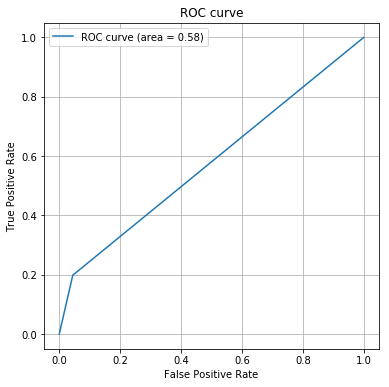

In [10]:
%matplotlib inline

# ROC 曲線
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr,label='ROC curve (area = %.2f)'%auc(fpr, tpr))
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig('ROC.png')
plt.show()

### 決定木の可視化

In [11]:
#!conda install python-graphviz
#!pip install pydotplus

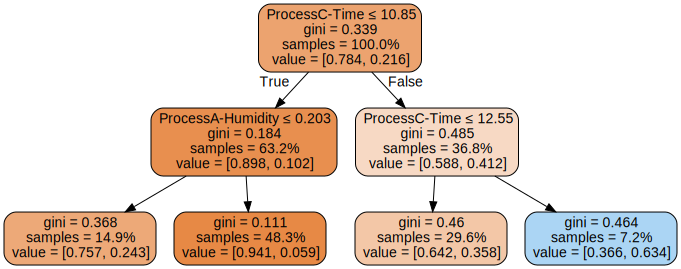

In [12]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, proportion=True, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [13]:
graph.render(filename="factory-tree", format='png')

'factory-tree.png'

In [14]:
# # Graph の保存
# import pydotplus as pdp
# graph = pdp.graph_from_dot_data(dot_data)
# graph.write_png("factory-tree.png")

## メトリックの記録

Experiment に紐づけて、利用したハイパーパラメータやモデル精度を記録します。

In [15]:
# パラメータ
run.log("木の分割基準", criterion)
run.log("木の深さ", max_depth)

# 精度
run.log("AUC", auc(fpr, tpr))
run.log("正解率", accuracy_score(pred, y_test))

# 画像記録
run.log_image("ROC", "ROC.png")
run.log_image(name = "DT image", path="factory-tree.png")

### モデル登録

In [16]:
import pickle
filename = 'DT-model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [17]:
run.upload_file("outputs/"+filename, filename)

# モデル登録

Azure Machine Learning service 上にモデルを保存します。

In [18]:
from azureml.core.model import Model

model = run.register_model(model_name='DT-sklearn', 
                           model_path = 'outputs/' + filename,
                           tags = {'area': "sklearnによる決定木", 'type': "分類 Classification", 'run_id' : run.id}
                          )

In [19]:
print(model.name, model.version, model.tags)

DT-sklearn 16 {'area': 'sklearnによる決定木', 'type': '分類 Classification', 'run_id': 'da5eedc3-bac5-4e15-a716-c8273af5a5b8'}


## 実験完了

start_logging() で始めた Experiment を終了します。

In [20]:
run.complete()

In [21]:
# Git情報などの確認
run.get_details()

{'runId': 'da5eedc3-bac5-4e15-a716-c8273af5a5b8',
 'target': 'sdk',
 'status': 'Completed',
 'startTimeUtc': '2019-09-22T02:31:16.703927Z',
 'endTimeUtc': '2019-09-22T02:31:41.908815Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/konabuta/DataExplore-Workshop.git',
  'mlflow.source.git.repoURL': 'https://github.com/konabuta/DataExplore-Workshop.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '26376a64b9e3670aa7f706158f5b70fcfaea7c2d',
  'mlflow.source.git.commit': '26376a64b9e3670aa7f706158f5b70fcfaea7c2d',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': '1962669b-cfe7-4071-9294-f059ccc8efe8'},
 'logFiles': {}}

In [22]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
decisiontree-explore,da5eedc3-bac5-4e15-a716-c8273af5a5b8,,Completed,Link to Azure Portal,Link to Documentation
